In [3]:
# Step 1: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [5]:
# Step 2: Load and Preprocess Data
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values='?')

# Combine Date and Time into datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d/%m/%Y %H:%M:%S")
df.set_index('Datetime', inplace=True)

# Convert to numeric and drop NA
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['Global_active_power']].dropna()

# Resample to hourly mean
data_hourly = df.resample('h').mean()

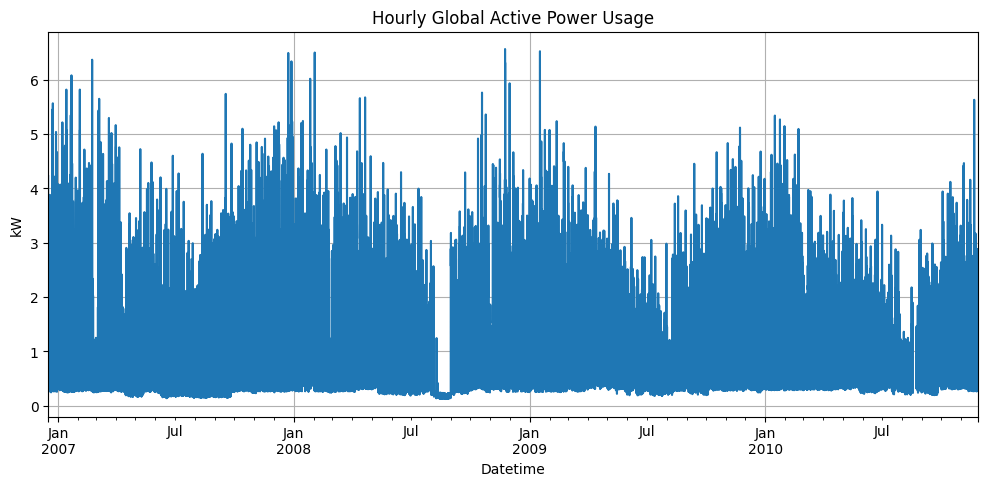

In [6]:
# Step 3: Visualize Time Series
plt.figure(figsize=(12, 5))
data_hourly['Global_active_power'].plot()
plt.title('Hourly Global Active Power Usage')
plt.ylabel('kW')
plt.grid()
plt.show()

In [7]:
# Step 4: Feature Engineering for XGBoost
df_feat = data_hourly.copy()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month
df_feat['lag1'] = df_feat['Global_active_power'].shift(1)
df_feat['lag24'] = df_feat['Global_active_power'].shift(24)
df_feat = df_feat.dropna()

# Split into train/test
train = df_feat.loc[:'2009-10-31']
test = df_feat.loc['2009-11-01':]

X_train = train.drop('Global_active_power', axis=1)
y_train = train['Global_active_power']
X_test = test.drop('Global_active_power', axis=1)
y_test = test['Global_active_power']

In [9]:
# Step 5: ARIMA Model
arima_model = ARIMA(data_hourly['Global_active_power'][:'2009-10-31'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.predict(
    start=len(data_hourly[:'2009-10-31']),
    end=len(data_hourly[:'2009-10-31']) + len(test) - 1
)

In [11]:
# Step 6: Prophet Model
df_prophet = data_hourly.reset_index().rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
train_prophet = df_prophet[df_prophet['ds'] <= '2009-10-31']
test_prophet = df_prophet[df_prophet['ds'] > '2009-10-31']

prophet_model = Prophet()
prophet_model.fit(train_prophet)
future = prophet_model.make_future_dataframe(periods=len(test), freq='h')
forecast = prophet_model.predict(future)
prophet_pred = forecast.set_index('ds').loc['2009-11-01':]['yhat']

22:57:32 - cmdstanpy - INFO - Chain [1] start processing
22:57:49 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Step 7: XGBoost Model
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [18]:
# Step 8: Evaluation
def evaluate(true, pred, model_name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f'{model_name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}')

# Print lengths for debugging
print("y_test length:", len(y_test))
print("prophet_pred length:", len(prophet_pred))
print("arima_pred length:", len(arima_pred))
print("xgb_pred length:", len(xgb_pred))

# Evaluate only with aligned lengths
evaluate(y_test[:len(arima_pred)], arima_pred, 'ARIMA')
evaluate(y_test[:len(prophet_pred)], prophet_pred.values, 'Prophet')
evaluate(y_test[:len(xgb_pred)], xgb_pred, 'XGBoost')


y_test length: 8995
prophet_pred length: 8972
arima_pred length: 8995
xgb_pred length: 8995
ARIMA -> MAE: 0.665, RMSE: 0.819
Prophet -> MAE: 0.650, RMSE: 0.828
XGBoost -> MAE: 0.362, RMSE: 0.524


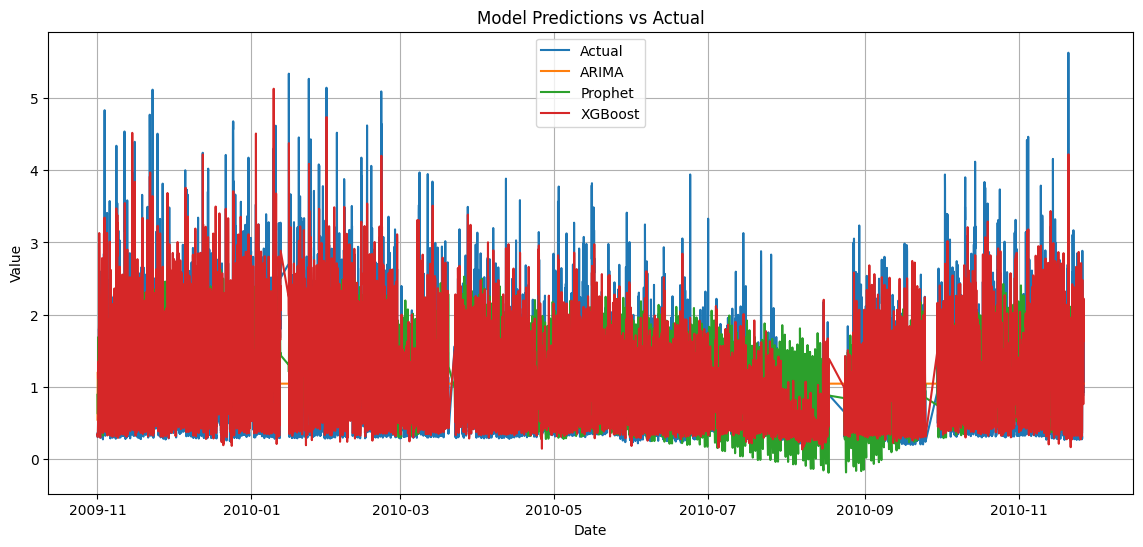

In [20]:
# Step 9: Plot Actual vs Predicted
plt.figure(figsize=(14, 6))

# Plot actual
plt.plot(y_test.index, y_test.values, label='Actual')

# Plot ARIMA (assumed same length as y_test)
plt.plot(y_test.index, arima_pred, label='ARIMA')

# Plot Prophet — use same length for index and prediction
plt.plot(y_test.index[:len(prophet_pred)], prophet_pred.values, label='Prophet')

# Plot XGBoost (assumed same length as y_test)
plt.plot(y_test.index, xgb_pred, label='XGBoost')

plt.legend()
plt.title('Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()